<a href="https://colab.research.google.com/github/aqu7he/DS-4002/blob/main/keras_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

!pip install livelossplot
!pip install tensorflow
!pip install keras

import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from livelossplot import PlotLossesKerasTF
import tensorflow as tf

In [ ]:
! git clone https://github.com/spenceryee/CS229

Cloning into 'CS229'...
remote: Enumerating objects: 25127, done.
remote: Total 25127 (delta 0), reused 0 (delta 0), pack-reused 25127
Receiving objects: 100% (25127/25127), 1.62 GiB | 29.30 MiB/s, done.
Resolving deltas: 100% (577/577), done.
Updating files: 100% (2077/2077), done.


In [ ]:
folder_paths = ['/content/CS229/CK+/anger', '/content/CS229/CK+/contempt', '/content/CS229/CK+/disgust',
                '/content/CS229/CK+/fear', '/content/CS229/CK+/happiness', '/content/CS229/CK+/sadness',
                '/content/CS229/CK+/surprise']
# ChatGPT
file_list = []
for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files = [os.path.join(folder_path, f) for f in files]
    file_list.extend(files)

In [ ]:
combined_dir = '/content/combined_CK_data'
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Iterate through the folders in the data directory
for folder_name in os.listdir(combined_dir):
    folder_path = os.path.join(combined_dir, folder_name)
    if os.path.isdir(folder_path):
        # Count the number of files in the folder
        num_files = len(os.listdir(folder_path))
        print(f'there are {num_files} images displaying "{folder_name}",')

In [ ]:
import shutil

for file_path in file_list:
    folder_name = os.path.basename(os.path.dirname(file_path))
    file_name = os.path.basename(file_path)
    new_folder_path = os.path.join(combined_dir, folder_name)  # New folder path in combined directory
    os.makedirs(new_folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    new_file_path = os.path.join(new_folder_path, file_name)  # New file path with folder structure
    shutil.copy(file_path, new_file_path)

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Define parameters for image loading
batch_size = 128
image_size = (256, 256)  # Set the desired size for your images

# Create an instance of ImageDataGenerator for loading images
data_generator = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]

# Load images from the directory
data_dir = '/content/train/'

In [40]:
# Create a data generator for training with data augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2
)

# Load images for training from the directory with a larger batch size
batch_size = 64  # Increase the batch size
train_generator = train_data_generator.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True
)



Found 260 images belonging to 7 classes.


In [ ]:
def save_images(images, output_dir, image_names=None, image_extension=".jpg"):
    """
    Save images as separate files in a specific directory.

    Parameters:
        images (list of numpy arrays): List containing images as numpy arrays.
        output_dir (str): Path to the directory where images will be saved.
        image_names (list of str, optional): List of image names. If None, default names will be used.
        image_extension (str, optional): Extension for the saved images. Default is ".jpg".

    Returns:
        None
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through the images and save them
    for i, image in enumerate(images):
        if image_names is not None:
            filename = image_names[i]
        else:
            filename = f"image_{i}"

        filepath = os.path.join(output_dir, f"{filename}{image_extension}")

        # Save the image using OpenCV
        cv2.imwrite(filepath, image)


In [ ]:
import cv2
from random import choice
from glob import glob
import fnmatch
from pathlib import Path

count =0

path_list = os.listdir("/content/combined_CK_data/anger/")
for x in path_list:
    target = fr"/content/combined_CK_data/anger/{x}"
    image = load_img(target, color_mode='grayscale')

    # Convert the image to a NumPy array
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Convert to batch with a single image
    image_array = image_array.astype('uint8')  # Ensure the datatype is uint8

    # Define augmentation parameters
    data_generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented versions of the image
    augmented_images = []
    num_augmented_images = 6  # Number of augmented images to generate
    images = np.toarray(augmented_images)
    for _ in range(num_augmented_images):
        augmented_image_array = data_generator.random_transform(image_array[0])
        augmented_image = array_to_img(augmented_image_array, data_format='channels_last')
        augmented_images.append(augmented_image)

    save_images(images, "/content/combined_CK_data/anger/")
    count += 1

In [ ]:
import os
import shutil

def split_folder(source_folder, folder1, folder2, split_ratio=0.5):
    """
    Split the contents of a folder into two separate folders.

    Parameters:
        source_folder (str): Path to the source folder containing files to split.
        folder1 (str): Path to the first destination folder.
        folder2 (str): Path to the second destination folder.
        split_ratio (float): Ratio of files to move to folder1. Value should be between 0 and 1. Default is 0.5.

    Returns:
        None
    """
    # Create destination folders if they don't exist
    os.makedirs(folder1, exist_ok=True)
    os.makedirs(folder2, exist_ok=True)

    # Get list of files in the source folder
    files = os.listdir(source_folder)
    num_files = len(files)

    # Calculate the number of files to move to folder1
    num_files_to_move = int(num_files * split_ratio)

    # Move files to folder1
    for file in files[:num_files_to_move]:
        src = os.path.join(source_folder, file)
        dst = os.path.join(folder1, file)
        shutil.move(src, dst)

    # Move remaining files to folder2
    for file in files[num_files_to_move:]:
        src = os.path.join(source_folder, file)
        dst = os.path.join(folder2, file)
        shutil.move(src, dst)

# Example usage
split_folder("/content/combined_CK_data/anger/", "anger_train", "anger_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/contempt/", "contempt_train", "contempt_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/disgust/", "disgust_train", "disgust_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/fear/", "fear_train", "fear_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/happiness/", "happiness_train", "happiness_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/sadness/", "sadness_train", "sadness_test", split_ratio=0.8)
split_folder("/content/combined_CK_data/surprise/", "surprise_train", "surprise_test", split_ratio=0.8)

In [25]:
import os
import shutil

def organize_folders(source_folder, text_identifier):
    """
    Organizes subfolders within a folder based on text in the directory names.

    Parameters:
        source_folder (str): Path to the source folder containing subfolders to organize.
        text_identifier (str): Text used to identify which subfolders should be moved.

    Returns:
        None
    """
    # Iterate through subfolders in the source folder
    for folder_name in os.listdir(source_folder):
        folder_path = os.path.join(source_folder, folder_name)

        # Check if the subfolder name contains the text identifier
        if text_identifier in folder_name and os.path.isdir(folder_path):
            # Create a destination folder based on the text identifier
            dest_folder = os.path.join(source_folder, text_identifier)
            os.makedirs(dest_folder, exist_ok=True)

            # Move the subfolder to the destination folder
            shutil.move(folder_path, dest_folder)

# Example usage
# Assuming you have a source folder containing subfolders and you want to organize them
# based on the text "identifier" in their names
source_folder = "/content/"
text_identifier = "test"
organize_folders(source_folder, text_identifier)

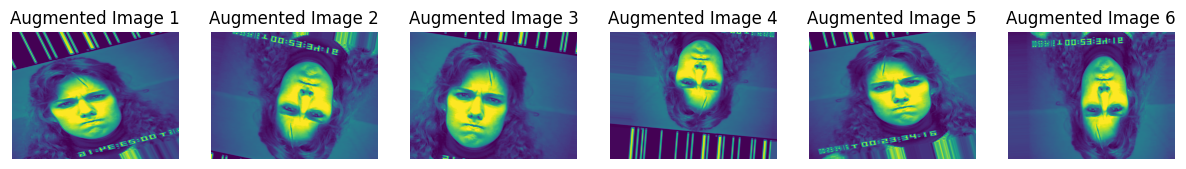

In [ ]:
plt.figure(figsize=(15, 6))
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, num_augmented_images, i + 1)
    plt.imshow(augmented_image)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')
plt.show()

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(img_size,img_size,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
#7 nodes in dense for 7 different emotions
model.add(Dense(7, activation='softmax'))

#compile model with accuracy
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 433671    
                                                                 
Total params: 452775 (1.73 MB)
Trainable params: 452775 (1.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
print("\nTraining dataset\n")
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")
print("\nTest dataset\n")
for expression in os.listdir("test/"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")


Training dataset

14 contempt_train images
55 happiness_train images
47 disgust_train images
20 fear_train images
36 anger_train images
22 sadness_train images
66 surprise_train images

Test dataset

9 anger_test images
12 disgust_test images
14 happiness_test images
17 surprise_test images
4 contempt_test images
6 sadness_test images
5 fear_test images


In [37]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

# train_generator = datagen_train.flow_from_directory("train/",
#                                                     target_size=(img_size,img_size),
#                                                     color_mode="grayscale",
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 67 images belonging to 7 classes.


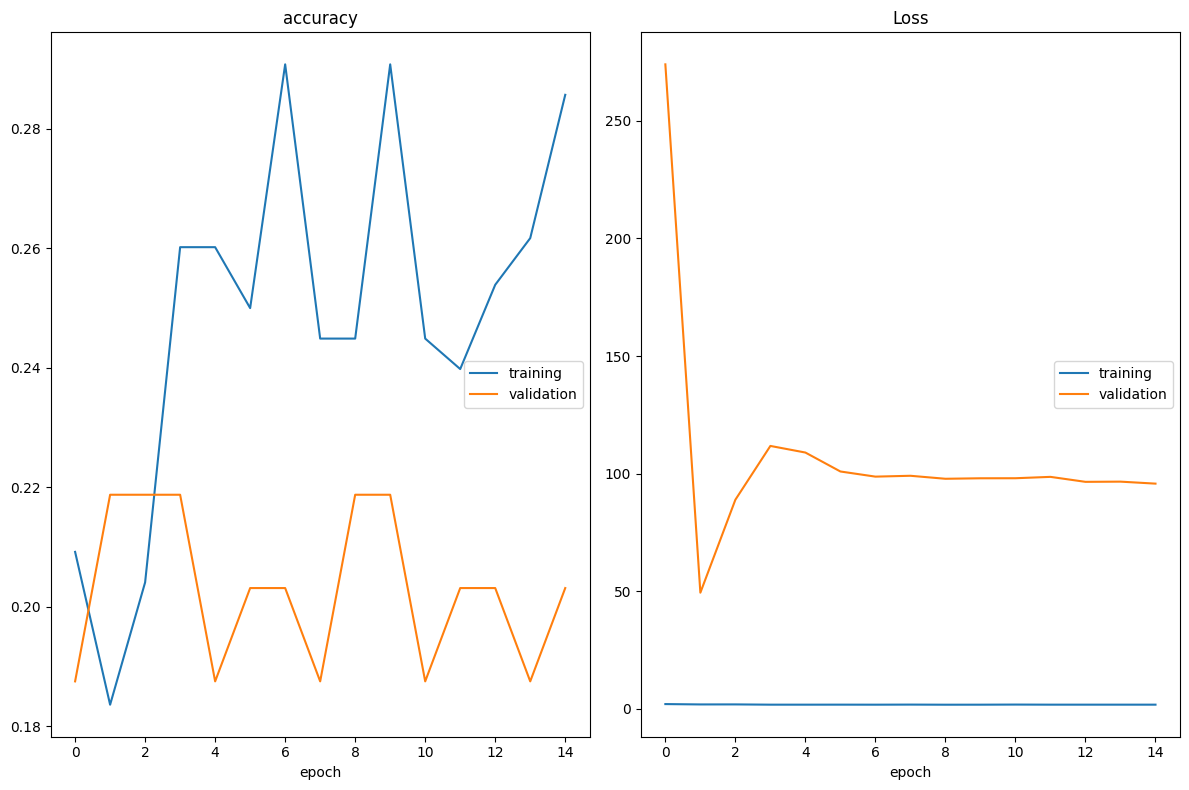

accuracy
	training         	 (min:    0.184, max:    0.291, cur:    0.286)
	validation       	 (min:    0.188, max:    0.219, cur:    0.203)
Loss
	training         	 (min:    1.771, max:    2.036, cur:    1.790)
	validation       	 (min:   49.396, max:  274.013, cur:   95.758)

Epoch 15: saving model to model_weights.h5
4/4 [==============================] - 4s 974ms/step - loss: 1.7902 - accuracy: 0.2857 - val_loss: 95.7581 - val_accuracy: 0.2031 - lr: 1.0000e-05
CPU times: user 1min 36s, sys: 7.16 s, total: 1min 44s
Wall time: 1min 29s


In [41]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)